### Import Modules

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from collections import Counter
import numpy as np
from func import visualizations

### The graphs

#### The Data

In [2]:
hero_df = pd.read_csv('hero-network.csv')
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')

#### Pre-processing

In [3]:
def preprocessing(df):
    
    # get rid of "/" at the end of the names
    df['hero1'] = df['hero1'].str.strip('/')
    df['hero2'] = df['hero2'].str.strip('/')
    
    # get rid of spaces at the end of the string
    df['hero1'] = df['hero1'].str.strip(' ')
    df['hero2'] = df['hero2'].str.strip(' ')
    
    # transform 'SPIDER-MAN/PETER PARKER' to 'SPIDER-MAN/PETER PAR' to match the name in edges.csv
    df['hero1'].replace('SPIDER-MAN/PETER PAR','SPIDER-MAN/PETER PARKER', inplace=True)
    df['hero2'].replace('SPIDER-MAN/PETER PAR','SPIDER-MAN/PETER PARKER', inplace=True)
    
    # Remove entries with same values in both columns in hero_df
    index_to_delete = df[df[['hero1','hero2']].nunique(axis=1) == 1].index
    df.drop(index_to_delete, axis=0, inplace=True)

    return df

In [4]:
hero_df = preprocessing(hero_df)
hero_df

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


#### Graphs

In [5]:
data = hero_df.copy()

In [6]:
# weigh G1 based on the number of collaborations

data = data.groupby(['hero1', 'hero2']).size().reset_index(name = 'count')
data['weight'] = 1/data['count'] # the inverse of the number of collaborations

In [181]:
data

,hero1,hero2,count,weight
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1,1.0
1,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1,1.0
2,24-HOUR MAN/EMMANUEL,M'SHULLA,1,1.0
3,3-D MAN/CHARLES CHAN,ANGEL/WARREN KENNETH,1,1.0
4,3-D MAN/CHARLES CHAN,ANT-MAN II/SCOTT HAR,1,1.0
...,...,...,...,...
224094,ZZZAX,"RODRIGUEZ, DEBRA",1,1.0
224095,ZZZAX,"ROSS, GEN. THADDEUS",2,0.5
224096,ZZZAX,"SUMMERS, NATHAN CHRI",1,1.0
224097,ZZZAX,TIGRA/GREER NELSON,1,1.0


In [7]:
G1 = nx.from_pandas_edgelist(data, 'hero1', 'hero2', edge_attr='weight')
G2 = nx.from_pandas_edgelist(edges_df, 'hero', 'comic')

### Functionality 1

Function **Functionality1** takes as inputs:
* the $Graph$ which, in our case, it's either $G1$ or $G2$
* $graphtype$ which takes values 1 or 2
* $nodes\_df$, the dataframe containing all the hero and comic nodes.
* $edges\_df$, the dataframe containing all the relationships between hero and comic nodes.
* and finally $N$, the number of top-N heroes we are considering in our analysis.

#### The Top_n heroes
**Top_n** is just a list of the $n$ heroes who have appeared in the most number of comics. We exploit the $value\_counts()$ function and we take the top $n$ heroes i.e., the ones having the highest degree or number of connections with the comic nodes and put those names ($.index$) in a list ($.tolist()$). As for $G1$ we are only interested in hero nodes, we just need to create a subgraph of $G1$ containing solely the heroes listed in $top\_n$. Instead, for $G2$ we are also interested in the comic nodes. Therefore, we need to recover the edge list from the $edges\_df$ which solely contains the connections between the $top\_n$ heroes and the comics they can be found in. Then, we build the sup graph using the $nx.from\_pandas\_edgelist()$ function from the newly defined edge list $edges\_df$.

#### 1.1 The number of nodes
For graph $G1$ we just need to use $Graph.nodes()$ function. For graph $G2$ it's slightly more complicated as we need to consider the $top\_n$ heroes as well as the comics that are linked to at least one of the $top\_n$ heroes. Once we identified those nodes in $nodes\_df$, we can group by node type and count ($.size()$) the number of hero nodes and comic nodes.

#### 1.2 The number of collaborations of each superhero with the others (only if type 1)
The number of collaborations is just the **degree** of each superhero ($Graph.degree()$). Functionality1 returns a dictionary having as keys the heroes and as values the degree or number of connections with the other superheroes in the graph.

#### 1.3 The number of heroes that have appeared in each comic (only if type 2)
Similarly as for $G1$, the number of heroes that have appeared in each comic is jus the degree of each comic. 

#### 1.4 The network's density
Found by using the $nx.density()$ function of $Networkx$.

#### 1.5 The network's degree distribution
The degree distribution is depicted in **Visualization1** through the use of an another function that creates the histogram.

#### 1.6 Average degree
The average degree is defined as the total sum of the degrees in the network over the number of nodes in the network.

#### 1.7 The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
First, we calculate the 95th percentile of the degree distribution by using $np.percentile()$. Then, we select only those nodes having degree greater than $perc$. Finally, we build a dataframe containing the **Network's Hubs** sorted in descending order according to their degree.

#### 1.8 Whether the Network is sparse or dense
$Density$ takes values between 0 and 1. The closer the density is to 1, the more dense the network is. I set the threshold to 50%. If the density is above 50% then, we consider the network *dense*, otherwise *sparse*.

In [8]:
def functionality1(Graph, graphtype, nodes_df, edges_df, N):
    
            
    top_n = edges_df['hero'].value_counts().iloc[:N].index.tolist() # list of top_n heroes
    edges_df = edges_df[edges_df.hero.isin(top_n)] # get only the edges (connections) where the hero is in the top_n
    
    if graphtype == 1:
        
        if N == len(Graph.nodes()):
            sub_Graph = Graph
        else:
            sub_Graph = Graph.subgraph(top_n)
        
        nodes = len(sub_Graph.nodes()) # number of nodes
        
        degree = dict(sub_Graph.degree()) # number of collaborations = degree (number of connections) of each superhero
        
        
    elif graphtype == 2:
        
        sub_Graph = nx.from_pandas_edgelist(edges_df, 'hero', 'comic') # build a graph starting from the newly defined edges_df
        
        # get only those nodes that either are in the top_n (heroes) or comic nodes that are connected to the top_n hero nodes
        nodes_df = nodes_df[(nodes_df.node.isin(top_n)) | (nodes_df.node.isin(edges_df[edges_df.hero.isin(top_n)].comic.unique().tolist()))]
        nodes = nodes_df.groupby('type').size() # number of nodes for each type (hero or comic)
        
        degree = dict(sub_Graph.degree(edges_df['comic']))
        
        
    # average degree
    avg_deg = round(sum(degree.values())/len(degree), 2)
    
    # 95th percentile
    perc = np.percentile(list(degree.values()), 95)
    hubs, hub_degree = [], []
    for node in degree:
        if degree[node] > perc:
            hubs.append(node)
            hub_degree.append(degree[node])
        
    # hubs dataframe sorted in descending order by degree
    hubs_df = pd.DataFrame({'hub':hubs,
                            'degree':hub_degree}).sort_values('degree', ascending = False).reset_index(drop=True)
    
    
    # network density
    density = round(nx.density(sub_Graph), 5)
    
    if density > 0.5: # maximum density is 1 for complete graphs
        is_dense = "dense"
    else:
        is_dense = "sparse"
        
        
    return nodes, density, degree, avg_deg, is_dense, hubs_df

### Visualization 1

#### 1.1 A table containing the following general information about the graph: Number of nodes in the network, Density of the network. Average degree of the network, Whether the network is sparse or dense

#### Example1: N = 40

* Let's let $N$ to 40. Therefore, we are considering the $top\_40$ hero nodes (listed in $edges\_df$).

In [14]:
nodes_G1, density_G1, degree_G1, avg_deg_G1, is_dense_G1, hubs_df_G1 = functionality1(G1, 1, nodes_df, edges_df, 40)
nodes_G2, density_G2, degree_G2, avg_deg_G2, is_dense_G2, hubs_df_G2 = functionality1(G2, 2, nodes_df, edges_df, 40)

* As can be seen in the table below, the number of hero nodes is equal to 39 even though we wanted the $top\_40$ heroes. This means that at least one of the nodes listed in $edges\_df$ is not in $nodes\_df$.
* The number of comic nodes is much larger than the number of hero nodes, this is way theh network's density is a lot smaller than for $G1$.

In [15]:
table_G1 = [['number of nodes', 'density', 'average degree', 'dense or sparse'], 
         [nodes_G1, density_G1, avg_deg_G1, is_dense_G1]]

print(tabulate(table_G1, tablefmt='grid'))

+-----------------+---------+----------------+-----------------+
| number of nodes | density | average degree | dense or sparse |
+-----------------+---------+----------------+-----------------+
| 40              | 0.98974 | 38.6           | dense           |
+-----------------+---------+----------------+-----------------+


In [16]:
table_G2 = [['number of comic nodes', 'number of hero nodes', 'density', 'average degree', 'dense or sparse'], 
            [nodes_G2[0], nodes_G2[1], density_G2, avg_deg_G2, is_dense_G2]]

print(tabulate(table_G2, tablefmt='grid'))

+-----------------------+----------------------+---------+----------------+-----------------+
| number of comic nodes | number of hero nodes | density | average degree | dense or sparse |
+-----------------------+----------------------+---------+----------------+-----------------+
| 8464                  | 39                   | 0.00068 | 2.92           | sparse          |
+-----------------------+----------------------+---------+----------------+-----------------+


#### Example 2: N = all nodes
* Now, let's consider the whole Graphs $G1$ and $G2$. We will stick with this example until the end of $Visualization2$.

In [24]:
nodes_G1, density_G1, degree_G1, avg_deg_G1, is_dense_G1, hubs_df_G1 = functionality1(G1, 1, nodes_df, edges_df, len(G1.nodes()))
nodes_G2, density_G2, degree_G2, avg_deg_G2, is_dense_G2, hubs_df_G2 = functionality1(G2, 2, nodes_df, edges_df, len(G2.nodes()))

* Now, both graphs are sparse with less that $1$% density.

In [25]:
table_G1 = [['number of nodes', 'density', 'average degree', 'dense or sparse'], 
         [nodes_G1, density_G1, avg_deg_G1, is_dense_G1]]

print(tabulate(table_G1, tablefmt='grid'))

+-----------------+---------+----------------+-----------------+
| number of nodes | density | average degree | dense or sparse |
+-----------------+---------+----------------+-----------------+
| 6421            | 0.00811 | 52.05          | sparse          |
+-----------------+---------+----------------+-----------------+


In [26]:
table_G2 = [['number of comic nodes', 'number of hero nodes', 'density', 'average degree', 'dense or sparse'], 
            [nodes_G2[0], nodes_G2[1], density_G2, avg_deg_G2, is_dense_G2]]

print(tabulate(table_G2, tablefmt='grid'))

+-----------------------+----------------------+---------+----------------+-----------------+
| number of comic nodes | number of hero nodes | density | average degree | dense or sparse |
+-----------------------+----------------------+---------+----------------+-----------------+
| 12651                 | 6438                 | 0.00053 | 7.6            | sparse          |
+-----------------------+----------------------+---------+----------------+-----------------+


#### 1.2 A table that lists the network's hubs

* There are $320$ hubs in $G1$, as the 95th percentile of the degree distribution is equal to $190$.
* The three most important hubs are Captain America, Spiderman and Iron man.

In [27]:
hubs_df_G1

,hub,degree
0,CAPTAIN AMERICA,1903
1,SPIDER-MAN/PETER PARKER,1737
2,IRON MAN/TONY STARK,1521
3,THING/BENJAMIN J. GR,1416
4,MR. FANTASTIC/REED R,1377
...,...,...
315,VULTURE/ADRIAN TOOME,193
316,AJAK/TECUMOTZIN [ETE,192
317,HOBGOBLIN V/JASON PH,191
318,FIREFIST/RUSTY COLLI,191


* There are $553$ hubs in $G2$, as the 95th percentile of the degree distribution is equal to $19$.

In [28]:
hubs_df_G2

,hub,degree
0,COC 1,111
1,IW 3,91
2,IW 1,90
3,H2 279,87
4,IW 4,80
...,...,...
548,A 187,20
549,UX 384,20
550,A 168,20
551,A 100,20


#### 1.3 A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)

#### Barchart function

* We exploit the $degree\_dict$ found in $functionality1$ to build a **barchart** depicting the degree of the first 50 heroes ($.head(50)$) in descending order.

In [29]:
def barchart(degree_dict, color, node_type):
    
    nodes, degree = [], []
    for node in degree_dict:
        nodes.append(node)
        degree.append(degree_dict[node])

    # hubs dataframe sorted in descending order by degree
    deg_df = pd.DataFrame({'node':nodes,
                           'degree':degree}).sort_values('degree', ascending = False).reset_index(drop=True).head(50)

    fig = plt.figure(figsize = (20, 10))
 
    # creating the bar plot
    plt.bar(deg_df.node, deg_df.degree, color = color,
            width = 0.6)
    plt.xticks(rotation='vertical')
    plt.xlabel(str(node_type), size = 15)
    plt.ylabel("No. of collaborations", size = 15)
    plt.title("No. of collaborations of each " + str(node_type), size = 20)
    
    return plt.show()

* Obviously the plot below represents the **first 50 hubs** seen in *point 1.2*.

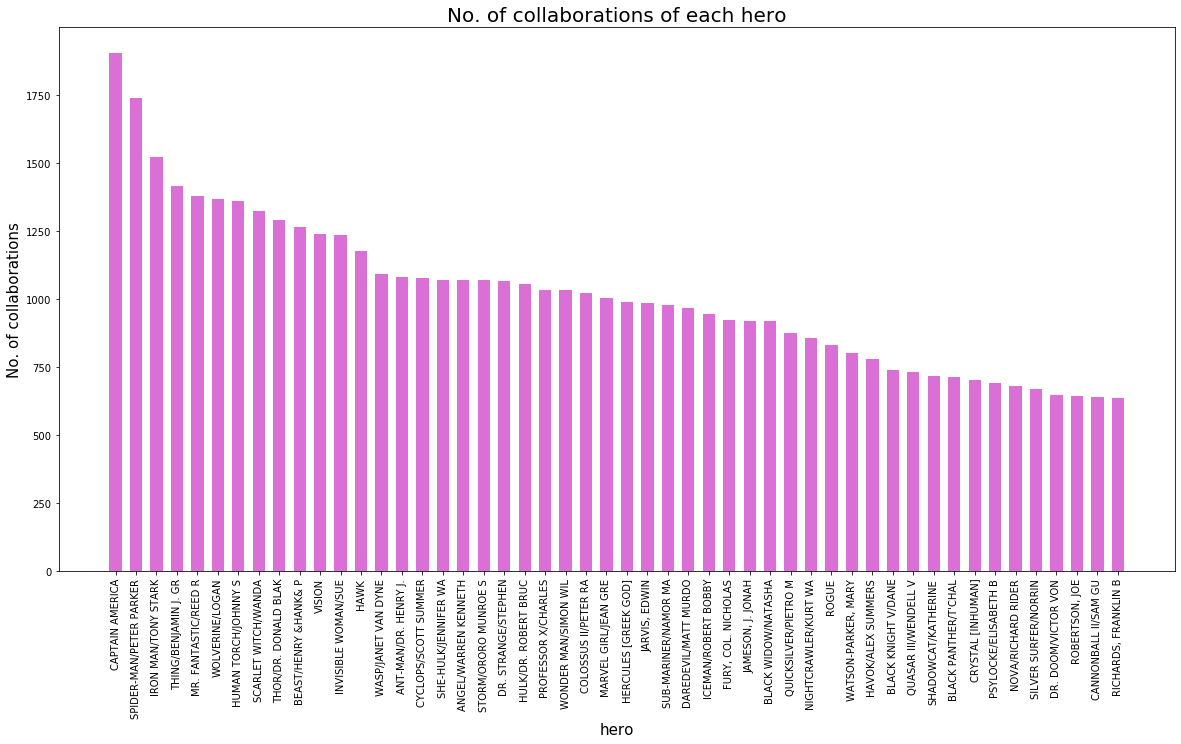

In [30]:
barchart(degree_G1, "orchid", "hero")

#### 1.4 A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

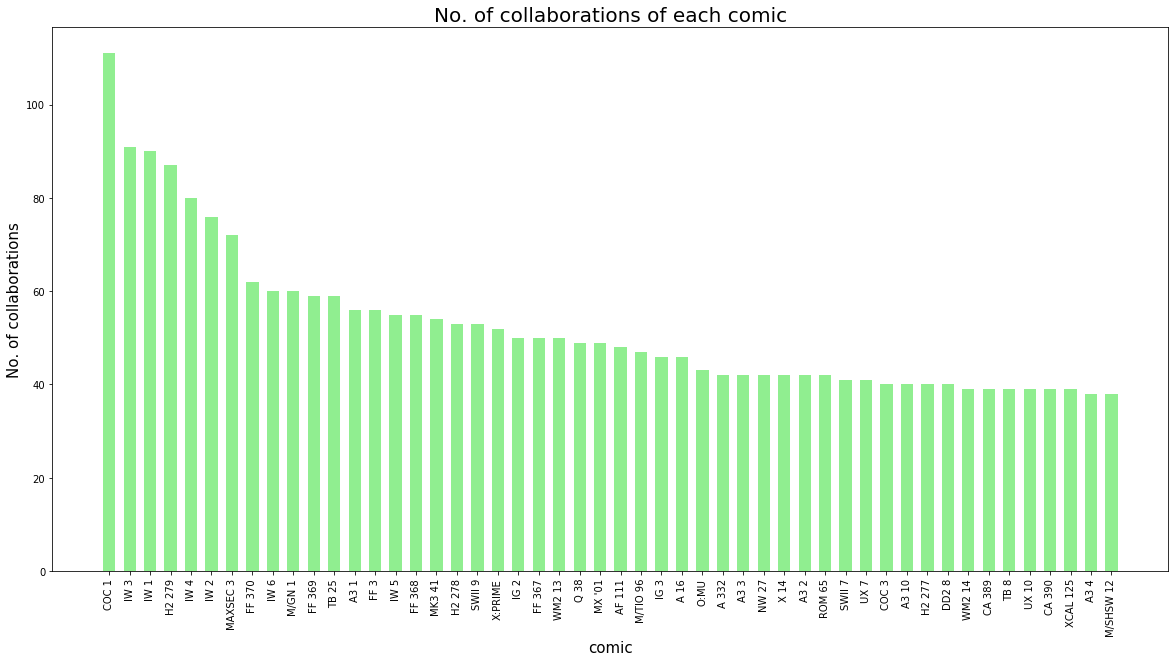

In [31]:
barchart(degree_G2, "lightgreen", "comic")

#### 1.5 A plot depicting the degree distribution of the network

#### The function

* We exploit the $degree\_dict$ found in $functionality1$ to build a **histogram** depicting the network's degree distribution.

In [32]:
def degree_distribution(degree_dict, color):
    
    degree_sequence = sorted([degree_dict[k] for k in degree_dict if degree_dict[k] < 200], reverse=True)  # degree sequence

    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    
    fig = plt.figure(figsize = (20, 10))
    plt.bar(deg, cnt, width=0.80, color=color)

    plt.title("Degree Histogram", size = 20)
    plt.ylabel("Count", size = 15)
    plt.xlabel("Degree", size = 15)

    return plt.show()

#### The plots

* Both distribution are really skewed, as the plots are heavily shifted to the left. This means that the majority of nodes in both networks have smaller degrees while only a few **"more popular" heroes or comics** have a much higher degree than the rest, equivalently those are the **hubs**.

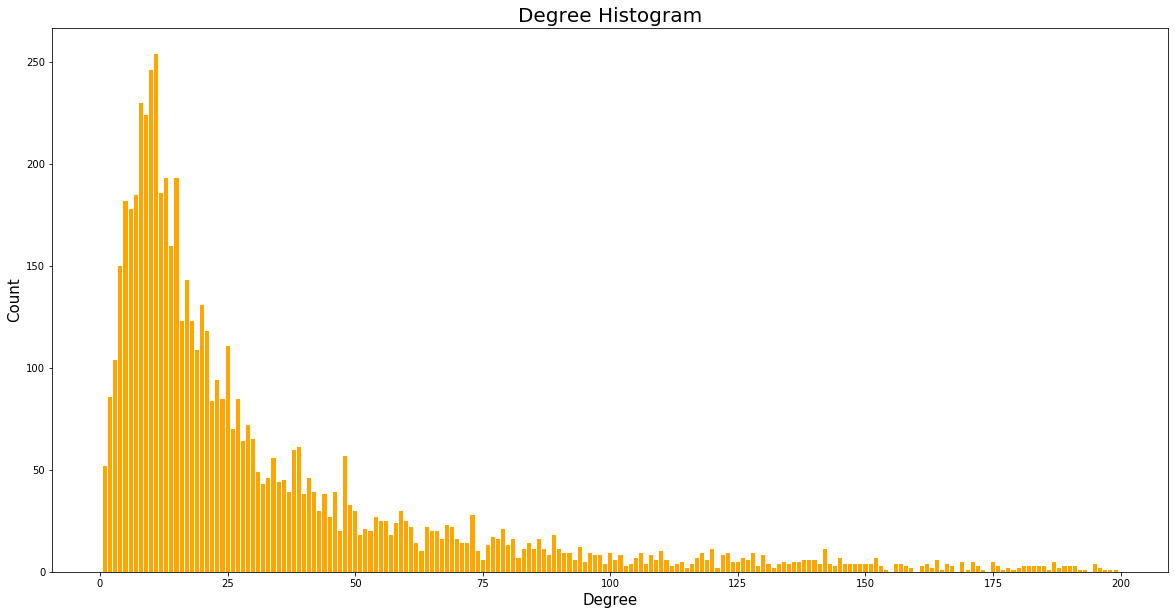

In [33]:
degree_distribution(degree_G1, 'orange')

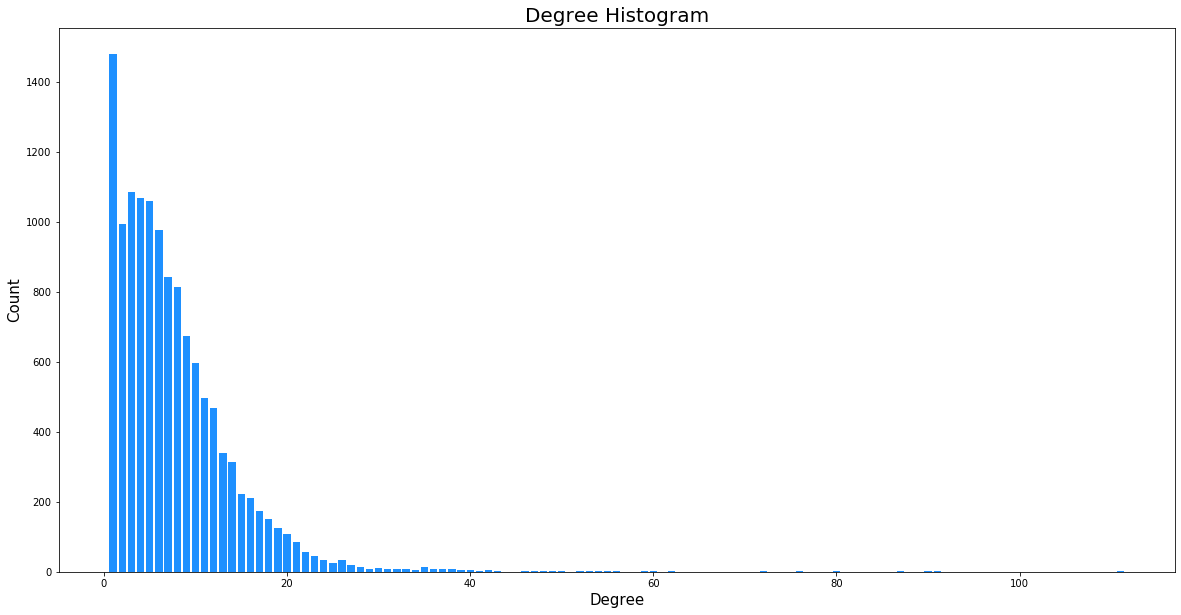

In [34]:
degree_distribution(degree_G2, 'dodgerblue')

### Functionality 2 - Find top superheroes!

As requested for this functionality, two outputs are given:
- Mean of the metric of the top N heros introduced.
- Metric of the especific node introduced


First we create a list containing only the top N heros in edges.csv. Then we calculate the input metric for every node in the graph, filter by only considering those heros in the top_n heros list, and then compute the mean of those heros' metrics. Finally we output the metric of the specific node inputed. Note that, given the time that takes computing betweenness centrality for the whole graph, we calculated in advanced and store it in a dictionary so its retrieval doesn't cause any issue. 
The output of our function is a dictionary, than contains the information of: node, metric, graph's metric and node's metric:

#### Graph's 1 example

In [32]:
functionality2(G1,"INVISIBLE WOMAN/SUE" , "DegreeCentrality", edges_df, 5, G1_betweenness)

{'Node': 'INVISIBLE WOMAN/SUE',
 'metric': 'Degree Centrality',
 'Graph_metric': array([0.29641745, 0.22056075, 0.23691589, 0.20077882, 0.27056075]),
 'Node_metric': 0.1925233644859813}

#### Graph's 2 example

In [34]:
functionality2(G2,"COC 1","DegreeCentrality", edges_df,5,G2_betweenness)

{'Node': 'COC 1',
 'metric': 'Degree Centrality',
 'Graph_metric': array([0.06988318, 0.06024412, 0.08261302, 0.0504479 , 0.0500812 ]),
 'Node_metric': 0.005814867201005815}

In [27]:
#Betweeness, PageRank, ClosenessCentrality, DegreeCentrality 
def functionality2(Graph, Node, metric, edges_df, N,betweenness):
    dict_output = {}   
    dict_output["Node"] = Node
    top_n = edges_df['hero'].value_counts().iloc[:N].index.tolist()
    #Metric
    if metric == "Betweeness":
        #graph
        dict_output["metric"] = "Betweeness Centrality"
        pd_page=pd.DataFrame.from_dict(betweenness,orient='index',columns=['centrality'])
        dict_output["Graph_metric"] = pd_page.centrality.values[pd_page.index.isin(top_n)]
        #node
        dict_output["Node_metric"] = G1_betweenness[Node]   
    elif metric == "PageRank":
        #graph
        dict_output["metric"] = "PageRank Centrality"
        m = nx.pagerank(Graph)
        pd_page=pd.DataFrame.from_dict(m,orient='index',columns=['centrality'])
        dict_output["Graph_metric"]  = pd_page.centrality.values[pd_page.index.isin(top_n)]
        #node
        dict_output["Node_metric"] = m[Node]
    elif metric == "ClosenessCentrality":
        #graph
        dict_output["metric"] = "Closeness Centrality"
        m = nx.closeness_centrality(Graph)
        pd_page=pd.DataFrame.from_dict(m,orient='index',columns=['centrality'])
        dict_output["Graph_metric"]  = pd_page.centrality.values[pd_page.index.isin(top_n)]
        #node
        dict_output["Node_metric"] = m[Node]
    elif metric == "DegreeCentrality":
        #graph
        dict_output["metric"] = "Degree Centrality"
        m = nx.degree_centrality(Graph)
        pd_page=pd.DataFrame.from_dict(m,orient='index',columns=['centrality'])
        dict_output["Graph_metric"] = pd_page.centrality.values[pd_page.index.isin(top_n)]
        #node
        dict_output["Node_metric"] = m[Node]
        
    return dict_output

### Visualization 2 - Visualize centrality measure

For a better visualization, we have created a function that shows in a table all the metrics of the top N heros of a given graph, and all the metrics of the specific node inputed.

In [28]:
def metric_table(graph,node, top_n, edges_df, betweenness):
    all_metrics = []
    all_lists = []
    metrics = ["Betweeness", "PageRank", "ClosenessCentrality", "DegreeCentrality"]
    for metric in metrics:
        f2 = functionality2(graph,node, metric, edges_df, top_n, betweenness)
        all_metrics.append(f2)
        all_lists.append([f2["metric"],f2["Node"],np.mean(f2["Graph_metric"]) , f2["Node_metric"]])

    table = [["Metric","Node","Mean of metric for top N heros", " Metric of Node"],all_lists[0], all_lists[1],all_lists[2],all_lists[3]]
    return tabulate(table, tablefmt='grid')

As requested for this functionality, two outputs are given:
 - Mean of the metric of the top N heros introduced.
 - Metric of the specific node introduced.

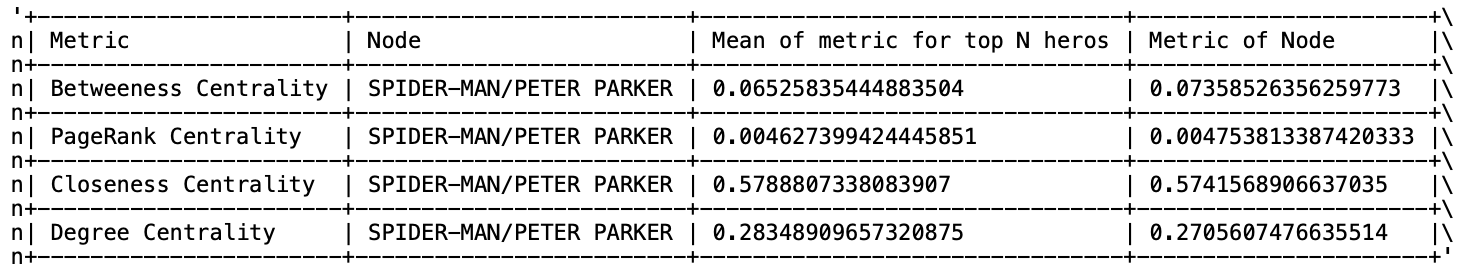

In [1]:
metric_table(G1,"SPIDER-MAN/PETER PARKER", 2, edges_df,G1_betweenness)

- **Betweeness Centrality**: tells us about the amount of influence a node has over the flow of whole graph. Spiderman's betweeness centrality score is the highest of the graph. It is calculated as the sum of all-pairs of shortest paths that pass through a node V, over the sum of all shortests paths between all nodes in the graph.
- **PageRank** Centrality: takes into account not only the amount of connections, but also the quality of those, the more influential they are, the higher the pagerank score will be. Spiderman's pagerank score is the highest of the graph.
- **Closeness Centrality**: measures how central is the node, it is calculated as the sum of all shortests paths to all nodes in the graph, and normalized by n-1 (the longest possible path). The bigger the metric, the more central a node is, actually Spiderman's 0.57 is the second highes closeness centrality in graph 1.
- **Degree Centrality**: it sums the weights of a node's connections, and then are normalized by dividing by n-1 where n is the number of nodes in G. Therefore, Spiderman's 0.27 is one on the highest of the graph 1.

### Functionality 4 + Visualization

REMARK: from then on we only refer to the first type of graph

For functionality 4 and 5, we thought that it was the case to change our interpretation of how to build the subgraph on which apply the functionalities.
We recall that prevoiusly we built the subgraph by filtering from the original graph the nodes contained in the list of the "top `N` heroes". If we do so, the consequent graph would only show the heroes contained in the list.
Now, since we want to keep the information related to the connections of the "top `N` heroes", we decided to proceed in another way:
* given `N`, we retrieve the "top `N` heroes" and reduce the original dataset to a smaller dataset containing the top `N` heroes. Then, we build the graph onto the reduced dataset. 

This way, heroes that are not in the "top `N` list" but are connected to the heroes in the list will appear in the graph.

In [8]:
def top_n (n=len(G1.nodes)):

    x = edges_df['hero'].value_counts().iloc[:n].index.tolist() 
    return x

In [53]:
top_n(8)

['SPIDER-MAN/PETER PARKER',
 'CAPTAIN AMERICA',
 'IRON MAN/TONY STARK',
 'THING/BENJAMIN J. GR',
 'THOR/DR. DONALD BLAK',
 'HUMAN TORCH/JOHNNY S',
 'MR. FANTASTIC/REED R',
 'HULK/DR. ROBERT BRUC']

In this part of the homework, we use a modified version of the previous dataset `data`. It is the same dataset but it is not alphabetically ordered.

In [9]:
data2 = hero_df.copy()
data2['weight'] = data2.groupby(['hero1','hero2'])['hero2'].transform('count').apply(lambda x: round(1/x,3))
data2

,hero1,hero2,weight
0,"LITTLE, ABNER",PRINCESS ZANDA,0.200
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.250
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,0.250
3,"LITTLE, ABNER",PRINCESS ZANDA,0.200
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.250
...,...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO,0.067
574463,CALLISTO,ROGUE,0.100
574464,CALLISTO,CALIBAN,0.200
574465,CALIBAN,ROGUE,0.167


Then, we introduce the function `sub_graph` that filter the dataset using`top_n` function and builds the corresponding graph. Notice that we further reduce the dataset for the first 250 rows for visualization's purposes. Moreover, we chose to use the `head` module of pandas instead of the surely more correct `sample` module, once again, for visualization's purposes.

In [10]:
def sub_graph(n,data=data2):
    
    sub_data = data[data['hero1'].isin(top_n(n))].head(250)
    G_original = nx.from_pandas_edgelist(sub_data ,'hero1','hero2', edge_attr = 'weight',edge_key = ['hero1','hero2'], create_using=nx.Graph)
    G = G_original.copy()
    return (G_original,G)
    

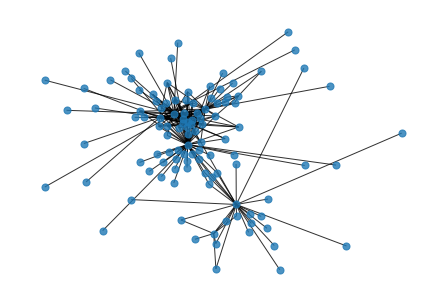

In [11]:
# example for top 10 heroes
n = 10
G_orignal = sub_graph(n)[1]              
nx.draw(G_orignal,node_size=50,alpha=0.8)

For functionality 4, we want to diconnect the graph into two subgraphs: one containing `heroA`, the other containing `heroB`.
The first thing we did was building the function `min_edge` that takes as input a graph and a path (a list of nodes). The function, then, outputs the shortest edge contained within the path and its length.
This functions was built by following a simple intution:
> If our goal is to cut the minimum distance between two nodes, we have to focus on all the paths conecting the two nodes and then cut the shortest edge of each path.

The function `min_edge` is then used inside `fun4` a function that takes as input two heroes, the reference dataset, and the number of top heroes that we want to consider.
`fun4` keeps on removing the shortest edge from a shortest path until the two nodes has completelly separated.

In [19]:
def min_edge(G,path):
    
    """ 
    Function that computes the minimum edge given a path
    
    Args:
        - G : a graph
        - path: a sequence of edges
        
    Returns:
        - the length of the minimum edge
        - the first node of the edge
        - the second node of the edge
    """
    
    # initialize output variables
    dist = np.inf # initialize the distance to infinite
    u1 = '' # variable that stores the first hero
    v1 = '' # variable that stores the second hero
    
    # iterate over all the edges of a path
    for i in range(len(path)-1):
        u = path[i]
        v = path[i+1]
        # reassign to `dist` the length of the current edge if it is less than `dist`
        if G[u][v]['weight'] < dist:
            dist = G[u][v]['weight']
            u1,v1 = u,v
            
    return ([dist,u1,v1])

def fun4(data=data2, heroA='CAPTAIN AMERICA',heroB='IRON MAN/TONY STARK', n = len(G1.nodes())):
    
    """ 
    Function that cuts the graph into two subgraphs 
    
    Args:
        - data : the dataset (default: data2)
        - heroA : one hero (default: 'CAPTAIN AMERICA')
        - heroB : another hero (default: 'IRON MAN/TONY STARK')
        - n : number of top heroes to consider
        
        
    Returns:
        - count : number of eges to remove
        - G_original : the original graph
        - G : the disconnected graphs
    """
    
    # initialize the needed variables
    G_original, G = sub_graph(n,data) 
    u = heroA
    v = heroB
    count = 0
    
    # check if both nodes are in the graph
    if v in list(G.nodes) and u in list(G.nodes):
        # iterate until there is a path connecting the two heroes
        while (nx.has_path(G,u,v)):
            path = list(nx.shortest_path(G,u,v)) # take the shortest path
            G.remove_edge(min_edge(G,path)[1],min_edge(G,path)[2]) # remove the smallest edge of the shortest path
            count +=1 # increase the count by one
            
    else:
        print('One or both the heroes are not contained in the graph')
        
    


    return (count, G_original, G)

Let's visualize an example with n=10

Number of edges to be removed:  6 



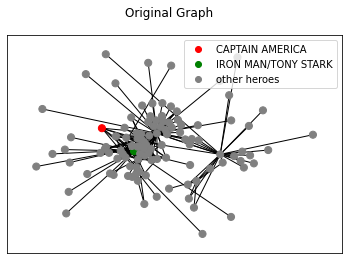

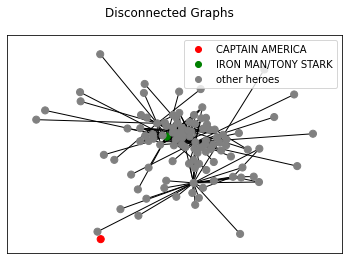

In [20]:
# VISUALIZATION 4 (see folder 'func')
count, G_original, G = fun4(n=10)
visualizations.vis4(count,G_original,G)

Let's check the result obtained with the built-in function `minimum_edge_cut`.

Number of edges to be removed:  6 



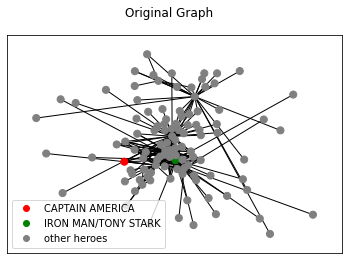

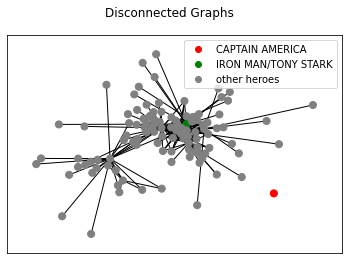

In [14]:
# function with built-in modules
def fun4_check(data=data2, heroA='CAPTAIN AMERICA',heroB='IRON MAN/TONY STARK', n = len(G1.nodes())):
    
    """ 
    Function that cuts the graph into two subgraphs 
    
    Args:
        - data : the dataset (default: data2)
        - heroA : one hero (default: 'CAPTAIN AMERICA')
        - heroB : another hero (default: 'IRON MAN/TONY STARK')
        - n : number of top heroes to consider
        
        
    Returns:
        - count : number of eges to remove
        - G_original : the original graph
        - G : the disconnected graphs
    """
    
    G_original, G = sub_graph(n,data)
    count = nx.edge_connectivity(G,heroA ,heroB) # retrieve the min number of edges to remove
    G.remove_edges_from(list(nx.minimum_edge_cut(G, heroA , heroB)))  # remove the edges coming from `min_edge_cut`   
    return (count, G_original, G)

# VISUALIZATION 4 (see folder 'func')
count, G_original, G = fun4_check(n=10)
visualizations.vis4(count ,G_original, G)


### Functionality 5 + Visualization

For functionality 5, we want to find communities existing in the graph.
The first thing we did was building the function `edge_to_remove` that takes as input a graph and outputs the edge that has to be removed on the basis of the highest `betweenness centrality`.
This functions was built by following a simple intuition:
> If our goal is to expose existing communities, we have to progressively remove the most valuable edges, aka the edges 
with highest betweenness centrality.

Then the function `fun5` keeps on removing the most valuable edge until the number of connected components is less that `k`, the number of communities that we want to create. 

In [21]:
def edge_to_remove(graph):
    
    """ 
    Function that finds the edge that has to be removed
    
    Args:
        - graph : a graph
        
    Returns:
        - edge : a tuple containing two nodes
    """    

    G_dict = nx.edge_betweenness_centrality(graph) # we retrieve a dictionary of all the edges with their scores
    edge = () # initialize a tuple to store the two nodes
    
    # extract the edge with highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
        edge = key
        break

    return edge

def fun5(heroA = 'CAPTAIN AMERICA', heroB= 'IRON MAN/TONY STARK', data=data2, n=len(G1.nodes()),k=2):
    
    """ 
    Function that divides the graph into k communities 
    
    Args:
        - data : the dataset (default: data2)
        - heroA : one hero (default: 'CAPTAIN AMERICA')
        - heroB : another hero (default: 'IRON MAN/TONY STARK')
        - n : number of top heroes to consider
        - k : number of communities to create
        
    Returns:
        - sg : the list of communities
        - count : number of eges to remove
        - G_original : the original graph
        - G : the communities graphs
    """
    
    G_original, G = sub_graph(n,data)
    sg_count = nx.number_connected_components(G_original) # number of connected components (that has to be equal to k)
    count = 0 # initialize the count variable
    
    # iterate until the number of connected components equals the number of communi
    while(sg_count < k):
        G.remove_edge(edge_to_remove(G)[0], edge_to_remove(G)[1]) # remove the nodes of the most valuable edge 
        count += 1 # increase the count by one
        sg_count = nx.number_connected_components(G) # recompute the number of connected components
    
    # retrieve the list of communities 
    sg = list(nx.connected_components(G))
    
    return (sg,count,G,G_original)
    

Let's visualize an example with n=10 and 2 communities

Number of edges to remove:  8 


               Community1            Community2
0     HAVOK/ALEX SUMMERS      MCCORMICK, BARRY
1   BEAST/HENRY &HANK& P     VENOM/EDDIE BROCK
2   SUMMERS, MADELYNE MA   WATSON-PARKER, MARY
3   JUBILEE/JUBILATION L  THOR/DR. DONALD BLAK
4   SUMMERS, NATHAN CHRI                DOLMAN
..                   ...                   ...
80    DRAGON OF THE MOON                   NaN
81   SCARLET WITCH/WANDA                   NaN
82  BANNER, BETTY ROSS T                   NaN
83                 ROGUE                   NaN
84      FORTUNE, DOMINIC                   NaN

[85 rows x 2 columns] 



/Users/davidevigneri/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


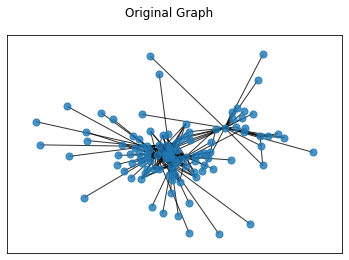

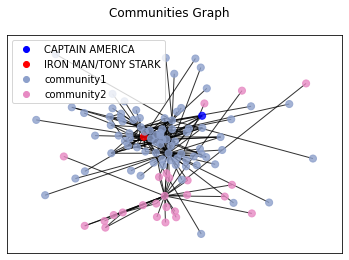

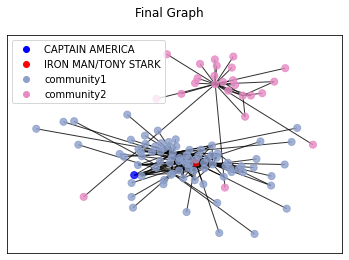

In [18]:
# VISUALIZATION 5 (see folder 'func')
communities,count,G_new,G = fun5(n=10,k=2)
visualizations.vis5(communities,count,G_new,G)

## Algorithmic Question

### Import the modules

In [1]:
import networkx as nx # to build the graph
import matplotlib.pyplot as plt # to plot the graph
from itertools import groupby

### The Graph

* We build the graph using the $grid\_2d\_graph$ from the $networkx$ package that returns a 2D **grid graph**, with $n,m=3$.
* The grid graph has each node connected to its nearest neighbors: two if it's a corner node ($node1$), three if it's an edge node ($node2$) and four if it's a center node ($node5$).
* This produces a graph with $9$ nodes and $12$ edges connecting the nodes. Each edge represents one of the possible line segment composing Sarah's phone password.

In [2]:
G = nx.grid_2d_graph(3, 3)

* Below we find a plot that helps us better visualize the graph.

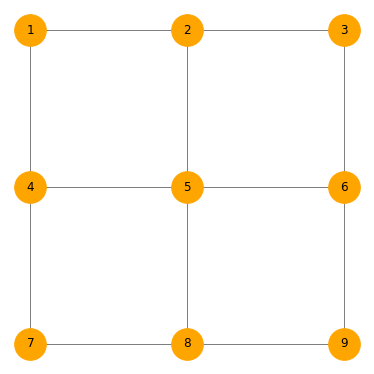

In [3]:
plt.figure(figsize=(5,5))
pos = {(x,y):(y,-x) for x,y in G.nodes()} # position of the nodes
labels = dict([(key, i+1) for i, key in enumerate(pos)]) # labels of the nodes
nx.draw(G, pos=pos,
        labels=labels,
        node_color='orange', 
        with_labels=True,
        node_size=1000,
        width=0.5)

### The Algorithm

In [4]:
# the user inserts the input, let's for example test 'DRU'
string = str(input('Insert the directions here: '))

Insert the directions here: DRU


In [5]:
print("The nodes of the graph G are", G.nodes())

The nodes of the graph G are [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


#### get_all_paths

* First we define the function $get\_all\_paths$ that takes as inputs the $Graph$, $node1$ and $node2$ and returns the list of    all paths linking the two nodes.
* To do so, we exploit the $Networkx$ built-in function called $all\_simple\_paths$ which lists all the paths (no loops or intersections) between $node1$ and $node2$.
* Each node is defined as a tuple of two integers that explain the *position* of the node in the graph. The numbers in the tuple refer to the position of the node in the graph with respect to the x-axis and the y-axis. For instance, $node 1$ is in position $(0,0)$, $node 2$ is in position $(1,0)$, $node 5$ is in position $(1,1)$, $node 9$ is in position $(2,2)$ and so on.

In [6]:
def get_all_paths(Graph, node1, node2):
    
    return [path for path in nx.all_simple_paths(Graph, node1, node2)]

print("The number of different patterns is equal to:", len(get_all_paths(G, (0, 1), (0, 2))))

The number of different patterns is equal to: 8


#### get_possible_paths

* We define another function $get\_possible\_paths$ that takes as inputs the $Graph$, $node1$, $node2$ and the $string$ which indicates the possible *ordered directions* that can be followed travelling across the graph.
* Therefore, we must choose only those paths (among all the paths) that go in certain specific directions, the ones imposed by the $string$.
* First, we get $all\_paths$ between $node1$ and $node2$ using the previously defined function $get\_all\_paths$.
* We reverse the order of the nodes in each path in $all\_paths$ and append the reversed paths $rev\_all\_paths$ to $all\_paths$ as we can travel across the graph in both directions *(bidirectional graph)*.
* Then, for each path we check the directions that are taken and store them into a string called $direct$.
  * **Right** if $node2[1] > node1[1]$. For instance, if we move from node-2 $(0,1)$ to node-3 $(0,2)$ we are moving one step to the      right. 
  * **Left** if $node2[1] < node1[1]$. 
  * **Down** if $node2[0] > node1[0]$. For instance, if we move from node-1 $(0,0)$ to node-4 $(1,0)$ we are moving one step to the      down. 
  * **Up** if $node2[0] < node1[0]$.
* Finally, we compare $direct$ with $string$ and choose only those paths that match the required directions imposed by $string$.
* The function outputs the number of paths ($count$) as well as the list of paths itself ($poss\_paths$).

In [ ]:
def get_possible_paths(Graph, node1, node2, string):
    
    all_paths = get_all_paths(Graph, node1, node2)
    rev_all_paths = [list(reversed(lst)) for lst in all_paths]
    all_paths = all_paths + rev_all_paths
    
    count = 0
    poss_paths = []

    for path in all_paths:
        direct = ""
        for node in range(0, len(path)-1):
            source = path[node]
            target = path[node+1]
            if target[1] > source[1]:
                direct += "R"
            elif target[1] < source[1]:
                direct += "L"
            elif target[0] > source[0]:
                direct += "D"
            elif target[0] < source[0]:
                direct += "U"  
        
        lst = [*string]
        lst_unique = [key for key, _group in groupby([*direct])]
        if lst == lst_unique:
            count += 1
            poss_paths.append(path)
        
    return count, poss_paths

* We can see that from the 8 paths that exist between node $(0,1)$ and node $(0,2)$, only 2

In [7]:
print(get_possible_paths(G, (0, 1), (0, 2), 'DRU'))

(2, [[(0, 1), (1, 1), (2, 1), (2, 2), (1, 2), (0, 2)], [(0, 1), (1, 1), (1, 2), (0, 2)]])


#### guess_my_password

* The last function called $guess\_my\_password$ takes as inputs the $Graph$, $string$ and the $labels$ that convert the node names $\{(0,0), (0,1) ... (2,2)\}$ to integer numbers from 1 to 9 that allow us to follow more easily the plot of the graph when checking the correctness of our algorithm.
* For each pair of nodes ($node1$, $node2$) we count the number of paths that follow the directions dictated by $string$ using the previously defined function $get\_possible\_paths$.
* we output the number ($count$) of possible patterns Alex has to try based on those directions to guess Sarah's password as well as the $count$ paths stored in a list named $poss\_paths\_num$.

In [8]:
def guess_my_password(Graph, string, labels):
    
    count = 0
    visited = []
    poss_paths = []
    
    for node1 in list(Graph.nodes()):
        for node2 in list(Graph.nodes()):
            if node1 != node2:
                if (node2, node1) not in visited:
                    visited.append((node2, node1))
                    visited.append((node1, node2))
                    count += get_possible_paths(Graph, node1, node2, string)[0]
                    path = get_possible_paths(Graph, node1, node2, string)[1]
                    
                    if len(path) > 0:
                        for sub in path:
                            poss_paths.append(sub)
    
    # change the name of the nodes in the path to integer numbers
    poss_paths_num = []
    for path in poss_paths:
        p = []
        for node in path:
            p.append(labels[node])    
        poss_paths_num.append(p)
                
    return count, poss_paths_num, poss_paths

#### Example 1

* Let's suppose that $string$ is equal to **'DRU'**. This means that the paths must follow those specific directions in that specific order (**Down-Right-Up**).
* In this case, the number of possible different patterns is 15.
* We can also see listed the paths.

In [9]:
count = guess_my_password(G, 'DRU', labels)[0]
poss_paths_num = guess_my_password(G, 'DRU', labels)[1]

print("The number of different patterns that only follow the directions Down-Right-Up is equal to:", count)

The number of different patterns that only follow the directions Down-Right-Up is equal to: 15


In [10]:
print(*poss_paths_num)

[1, 4, 7, 8, 5, 2] [1, 4, 5, 2] [1, 4, 7, 8, 9, 6, 3] [1, 4, 5, 6, 3] [1, 4, 7, 8, 5] [1, 4, 7, 8, 9, 6] [2, 5, 8, 9, 6, 3] [2, 5, 6, 3] [4, 7, 8, 5, 2] [2, 5, 8, 9, 6] [4, 7, 8, 9, 6, 3] [5, 8, 9, 6, 3] [4, 7, 8, 5] [4, 7, 8, 9, 6] [5, 8, 9, 6]


#### plot of the first Down-Right-Up path

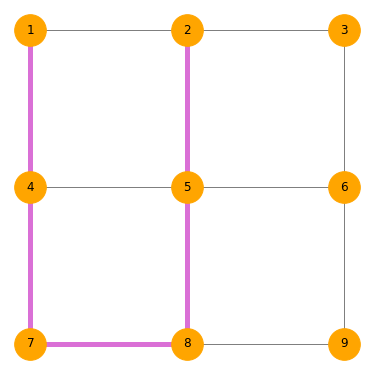

In [11]:
poss_paths = guess_my_password(G, 'DRU', labels)[2]
edges = [(path[node], path[node+1]) for path in poss_paths[:1] for node in range(len(path)-1)]
edges = [tup[::-1]  for tup in edges] + edges
edge_color = ['orchid' if edge in edges else 'black' for edge in G.edges()]
edge_width = [5 if edge in edges else 0.5 for edge in G.edges()]

plt.figure(figsize=(5,5))
nx.draw(G, pos=pos,
        labels=labels,
        node_color='orange', 
        with_labels=True,
        node_size=1000,
        edge_color=edge_color,
        width=edge_width)

#### Example 2

* Now, let's suppose that Sarah only moved her finger to the right. There obviously only are 9 possible combinantions of nodes. The same reasoning applies to only left, up or down.

In [12]:
count = guess_my_password(G, 'R', labels)[0]
poss_paths = guess_my_password(G, 'R', labels)[1]

print("The number of different patterns that only follow the direction Right is equal to:", count)

The number of different patterns that only follow the direction Right is equal to: 9


In [13]:
print(*poss_paths)

[1, 2] [1, 2, 3] [2, 3] [4, 5] [4, 5, 6] [5, 6] [7, 8] [7, 8, 9] [8, 9]


#### Example 3

* The combination of these directions produces a path where at least one node is repeated leading to an interesection. Therefore, the number of different patters following those specific directions is zero.

In [14]:
count = guess_my_password(G, 'LDRDRUL', labels)[0]
poss_paths = guess_my_password(G, 'LDRDRUL', labels)[1]

print("The number of different patterns that follow the directions Left-Down-Right-Down-Right-Up-Left is equal to:", count)

The number of different patterns that follow the directions Left-Down-Right-Down-Right-Up-Left is equal to: 0
